<hr>

# ST1511 AI and Machine Learning CA1 Assignment (Classification)
<hr>

Name: Lee Hong Yi <br>
Class: DAAA/FT/2A/05 <br>
Admin Number: p2223010 <br>

__Objective:__ <br>
Mitigate risk for a bank, by predicting if a customer will default on their payment.

__Background Information:__<br>
A bank has collected data on it's customers, such as their age, gender, level of education, credit limit, and payment history. From this data, the bank would like to predict if a customer would default on their bills, in a attempt to mitigate risk taken.

__Additional Information:__ <br>
A default is a missed or multiple missed payments on money that you have borrowed. An example of a default would be not paying your credit card bill or your monthly mortgage payment. (Investopedia, 2023)

__Prediction Task:__ <br>
Predicting if a customer will default on payments based on information such as gender, education, credit limit, and payment history.

__Output Variable:__ <br>
The output variable indicates if a customer defaulted on their next payment. A 0 indicates that the customer did not default, while a 1 indicates that the customer has defaulted.


<hr>
<font size = 5> Importing Libraries </font>
<hr>

In [324]:
# %pip install imblearn

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from warnings import simplefilter
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import ShuffleSplit, GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score

simplefilter(action='ignore', category=FutureWarning)
sns.set_style()

<hr>
<font size = 5> Preparing data </font>
<hr><br>
Since the data has already been collected, we can move straight onto preparing the data for training by the model.

Dropping columns, as well as creating a copy of the original dataframe to prevent it from being changed during EDA.

In [325]:
original_data = pd.read_csv("./credit_dataset.csv")
eda_data = original_data.copy()
target_data = original_data["Default payment next month"]
analysis_data = pd.DataFrame(original_data.drop(["Customer ID","Default payment next month"], axis  = 1))
analysis_data.head()

,Credit Limit,Gender,Education,Marriage Status,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3
0,20000,female,univeresity,married,24,3913,3102,689,0,689,0
1,120000,female,univeresity,single,26,2682,1725,2682,0,1000,1000
2,90000,female,univeresity,single,34,29239,14027,13559,1518,1500,1000
3,50000,female,univeresity,married,37,46990,48233,49291,2000,2019,1200
4,50000,male,univeresity,married,57,8617,5670,35835,2000,36681,10000


<hr>
<font size = 5>Exploratory Data Analysis</font>
<hr><br>
Before preparing the data to train the model, some exploratory data analysis shall be done first to gain some basic insights into the data.

In [326]:
eda_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Customer ID                 1600 non-null   int64 
 1   Credit Limit                1600 non-null   int64 
 2   Gender                      1600 non-null   object
 3   Education                   1600 non-null   object
 4   Marriage Status             1600 non-null   object
 5   Age                         1600 non-null   int64 
 6   Bill_Amount1                1600 non-null   int64 
 7   Bill_Amount2                1600 non-null   int64 
 8   Bill_Amount3                1600 non-null   int64 
 9   Pay_Amount1                 1600 non-null   int64 
 10  Pay_Amount2                 1600 non-null   int64 
 11  Pay_Amount3                 1600 non-null   int64 
 12  Default payment next month  1600 non-null   int64 
dtypes: int64(10), object(3)
memory usage: 162.6+ KB


From the above, we can see that there are 1600 records in the dataset. The Gender, Education, and Marriage Status columns are not integers, which means they will have to be handled seperately, possibly with one-hot encoding. We can also see that there are no null values in the dataset, which means that we will not have to drop any rows.

In [327]:
gender_count = eda_data["Gender"].value_counts()
education_count = eda_data["Education"].value_counts()
marriage_count = eda_data["Marriage Status"].value_counts()
default_count = eda_data["Default payment next month"].value_counts()

display(gender_count)
display(education_count)
display(marriage_count)
display(default_count)

female    940
male      660
Name: Gender, dtype: int64

univeresity      718
post-graduate    604
high school      278
Name: Education, dtype: int64

single     899
married    701
Name: Marriage Status, dtype: int64

0    1260
1     340
Name: Default payment next month, dtype: int64

Generating a boxplot showing the distribution of Credit Limit and Age.

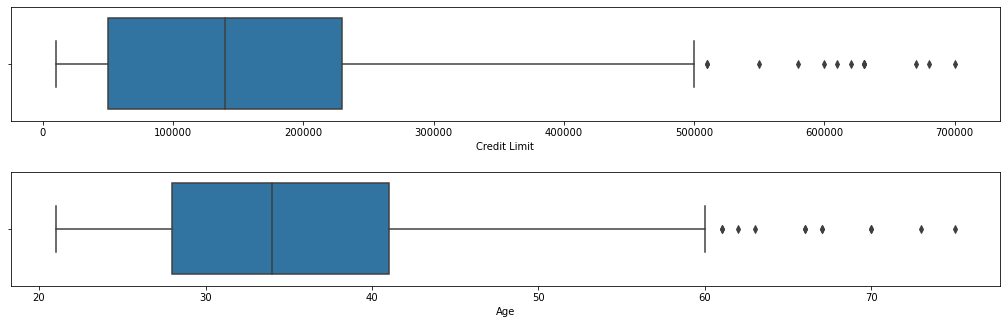

In [328]:
fig, ax = plt.subplots(2,1, figsize = (15,5))

fig.tight_layout(pad = 3.0)
sns.boxplot(data = eda_data, ax = ax[0], x = "Credit Limit")
sns.boxplot(data = eda_data, ax = ax[1], x = "Age")
plt.show()

Generating a boxplot showing the distribution of credit card bill amounts over the 3 months recorded.

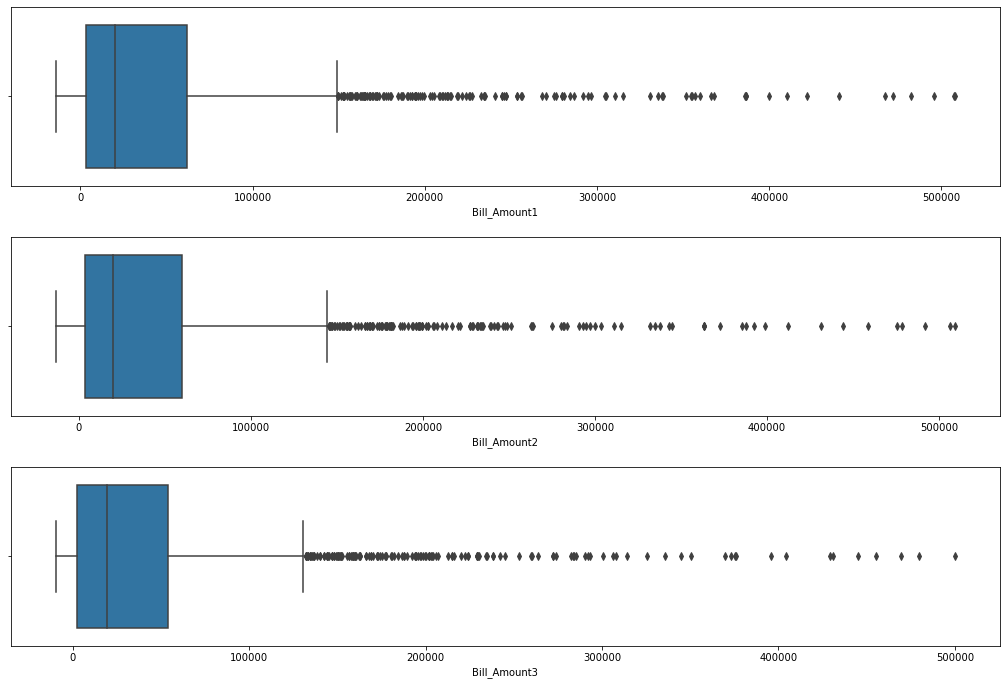

In [329]:
fig, ax = plt.subplots(3,1, figsize = (15,10))

fig.tight_layout(pad = 3.0)
sns.boxplot(data = eda_data, ax = ax[0], x = "Bill_Amount1")
sns.boxplot(data = eda_data, ax = ax[1], x = "Bill_Amount2")
sns.boxplot(data = eda_data, ax = ax[2], x = "Bill_Amount3")

plt.show()

Generating a boxplot showing the amount each customer paid over the 3 months recorded.

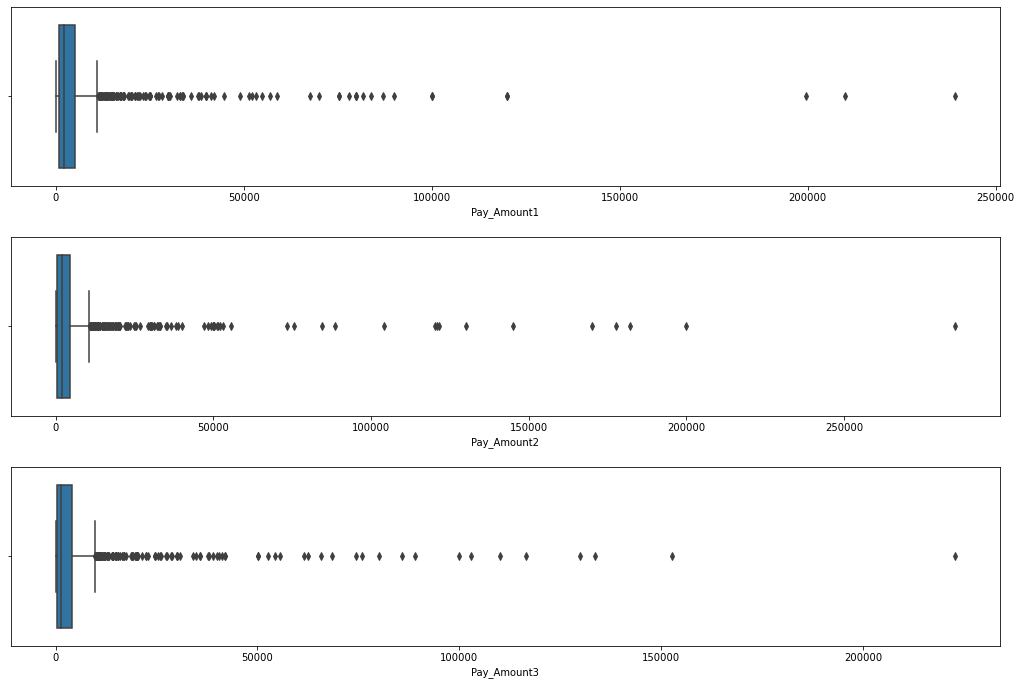

In [330]:
fig, ax = plt.subplots(3,1, figsize = (15,10))
fig.tight_layout(pad = 3.0)
sns.boxplot(data = eda_data, ax = ax[0], x = "Pay_Amount1")
sns.boxplot(data = eda_data, ax = ax[1], x = "Pay_Amount2")
sns.boxplot(data = eda_data, ax = ax[2], x = "Pay_Amount3")
plt.show()

Showing the distribution of defaulters based on the credit limit of the customers.

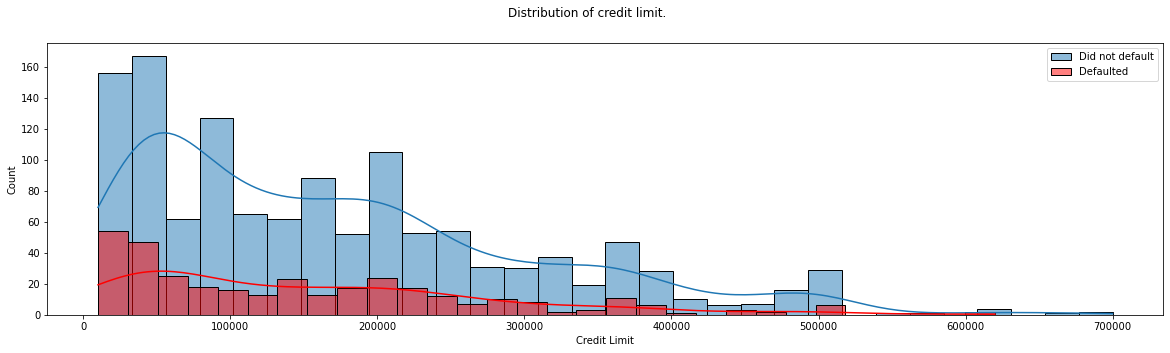

In [331]:
fig, ax = plt.subplots(figsize = (20,5))
fig = sns.histplot(eda_data[eda_data["Default payment next month"] == 0]["Credit Limit"], kde = True, bins = 30, label = "Did not default")
fig2 = sns.histplot(eda_data[eda_data["Default payment next month"] == 1]["Credit Limit"], kde = True, color = "red", bins = 30, label = "Defaulted")
plt.suptitle("Distribution of credit limit.")
ax.legend()
plt.show()

Showing the distribution of defaulters based on the age of the customers.

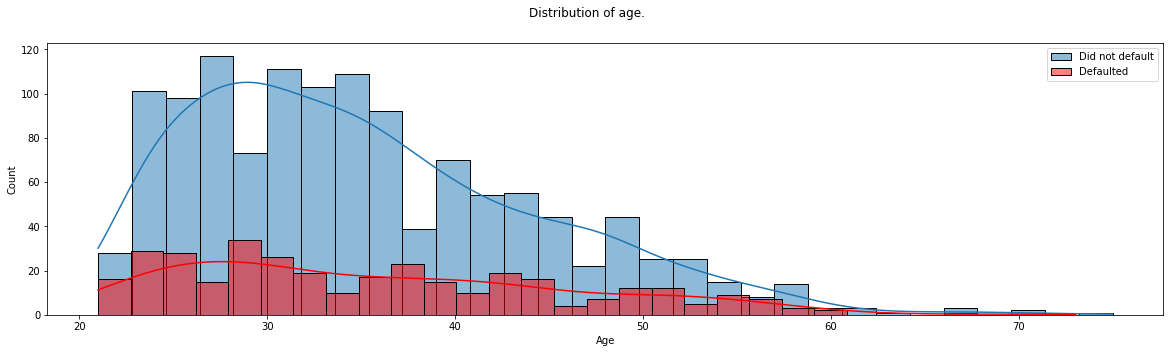

In [332]:
fig, ax = plt.subplots(figsize = (20,5))
fig = sns.histplot(eda_data[eda_data["Default payment next month"] == 0]["Age"], kde = True, bins = 30, label = "Did not default")
fig2 = sns.histplot(eda_data[eda_data["Default payment next month"] == 1]["Age"], kde = True, color = "red", bins = 30, label = "Defaulted")
plt.suptitle("Distribution of age.")
ax.legend()
plt.show()

Showing the gender distributrion of the customers.

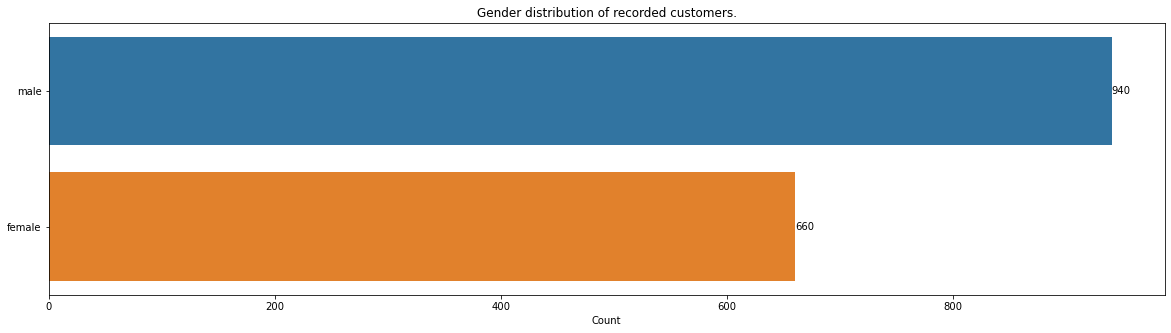

In [333]:
data_count = list(gender_count)
# display(gender_count[0])
gender_count_dict = dict(male = gender_count[0],female=gender_count[1])
gender_count_dict = pd.DataFrame(data = gender_count_dict, index = ["Count"])
gender_count_dict = gender_count_dict.T
# display(gender_count_dict)
plt.figure(figsize = (20,5))
ax = sns.barplot(data = gender_count_dict, x = "Count", y = gender_count_dict.index)
ax.set(title = "Gender distribution of recorded customers.")
for i in ax.containers:
    ax.bar_label(i,)


Showing distribution of the customers who defaulted.

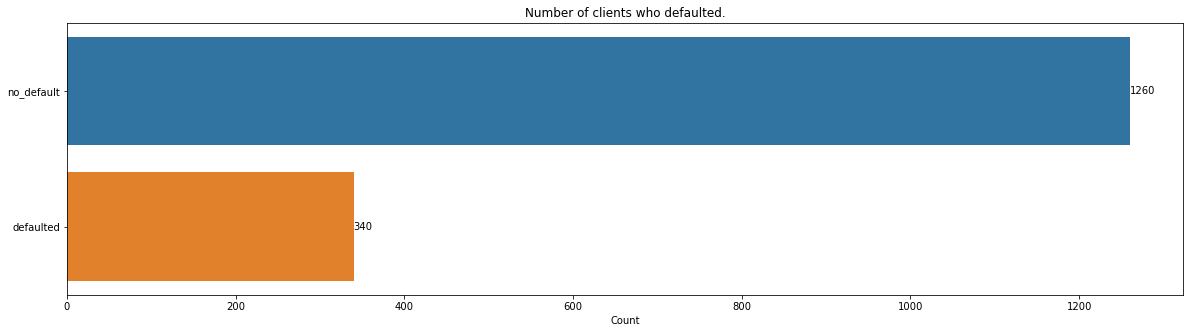

In [334]:
data_count = list(default_count)
# display(gender_count[0])
default_count_dict = dict(no_default = default_count[0], defaulted=default_count[1])
default_count_dict = pd.DataFrame(data = default_count_dict, index = ["Count"])
default_count_dict = default_count_dict.T
plt.figure(figsize = (20,5))
ax = sns.barplot(data = default_count_dict, x = "Count", y = default_count_dict.index)
ax.set(title = "Number of clients who defaulted.")
for i in ax.containers:
    ax.bar_label(i,)

From the above graph, we can see that the dataset is imbalanced, with a significantly larger amount of no_default samples at 1260 compared to defaulted, at 340. <br>
As this is the target variable, it is imperative that that we balance the dataset, as having a imbalance in the target variable will result in poorer model performance. <br>
Hence, we will carry out oversampling to balance the dataset later. 

Correleation plot to show how the variables in the dataset are correlated with each other.

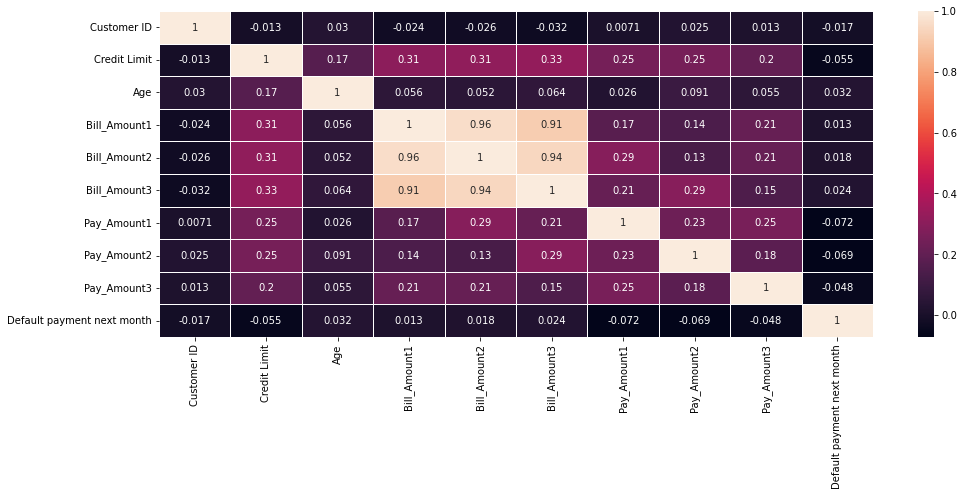

In [335]:
plt.figure(figsize = (16,6))
sns.heatmap(eda_data.corr(), annot = True, linewidths= 0.5)
plt.show()

Generating a pairplot to view the relationships between variables in more detail.


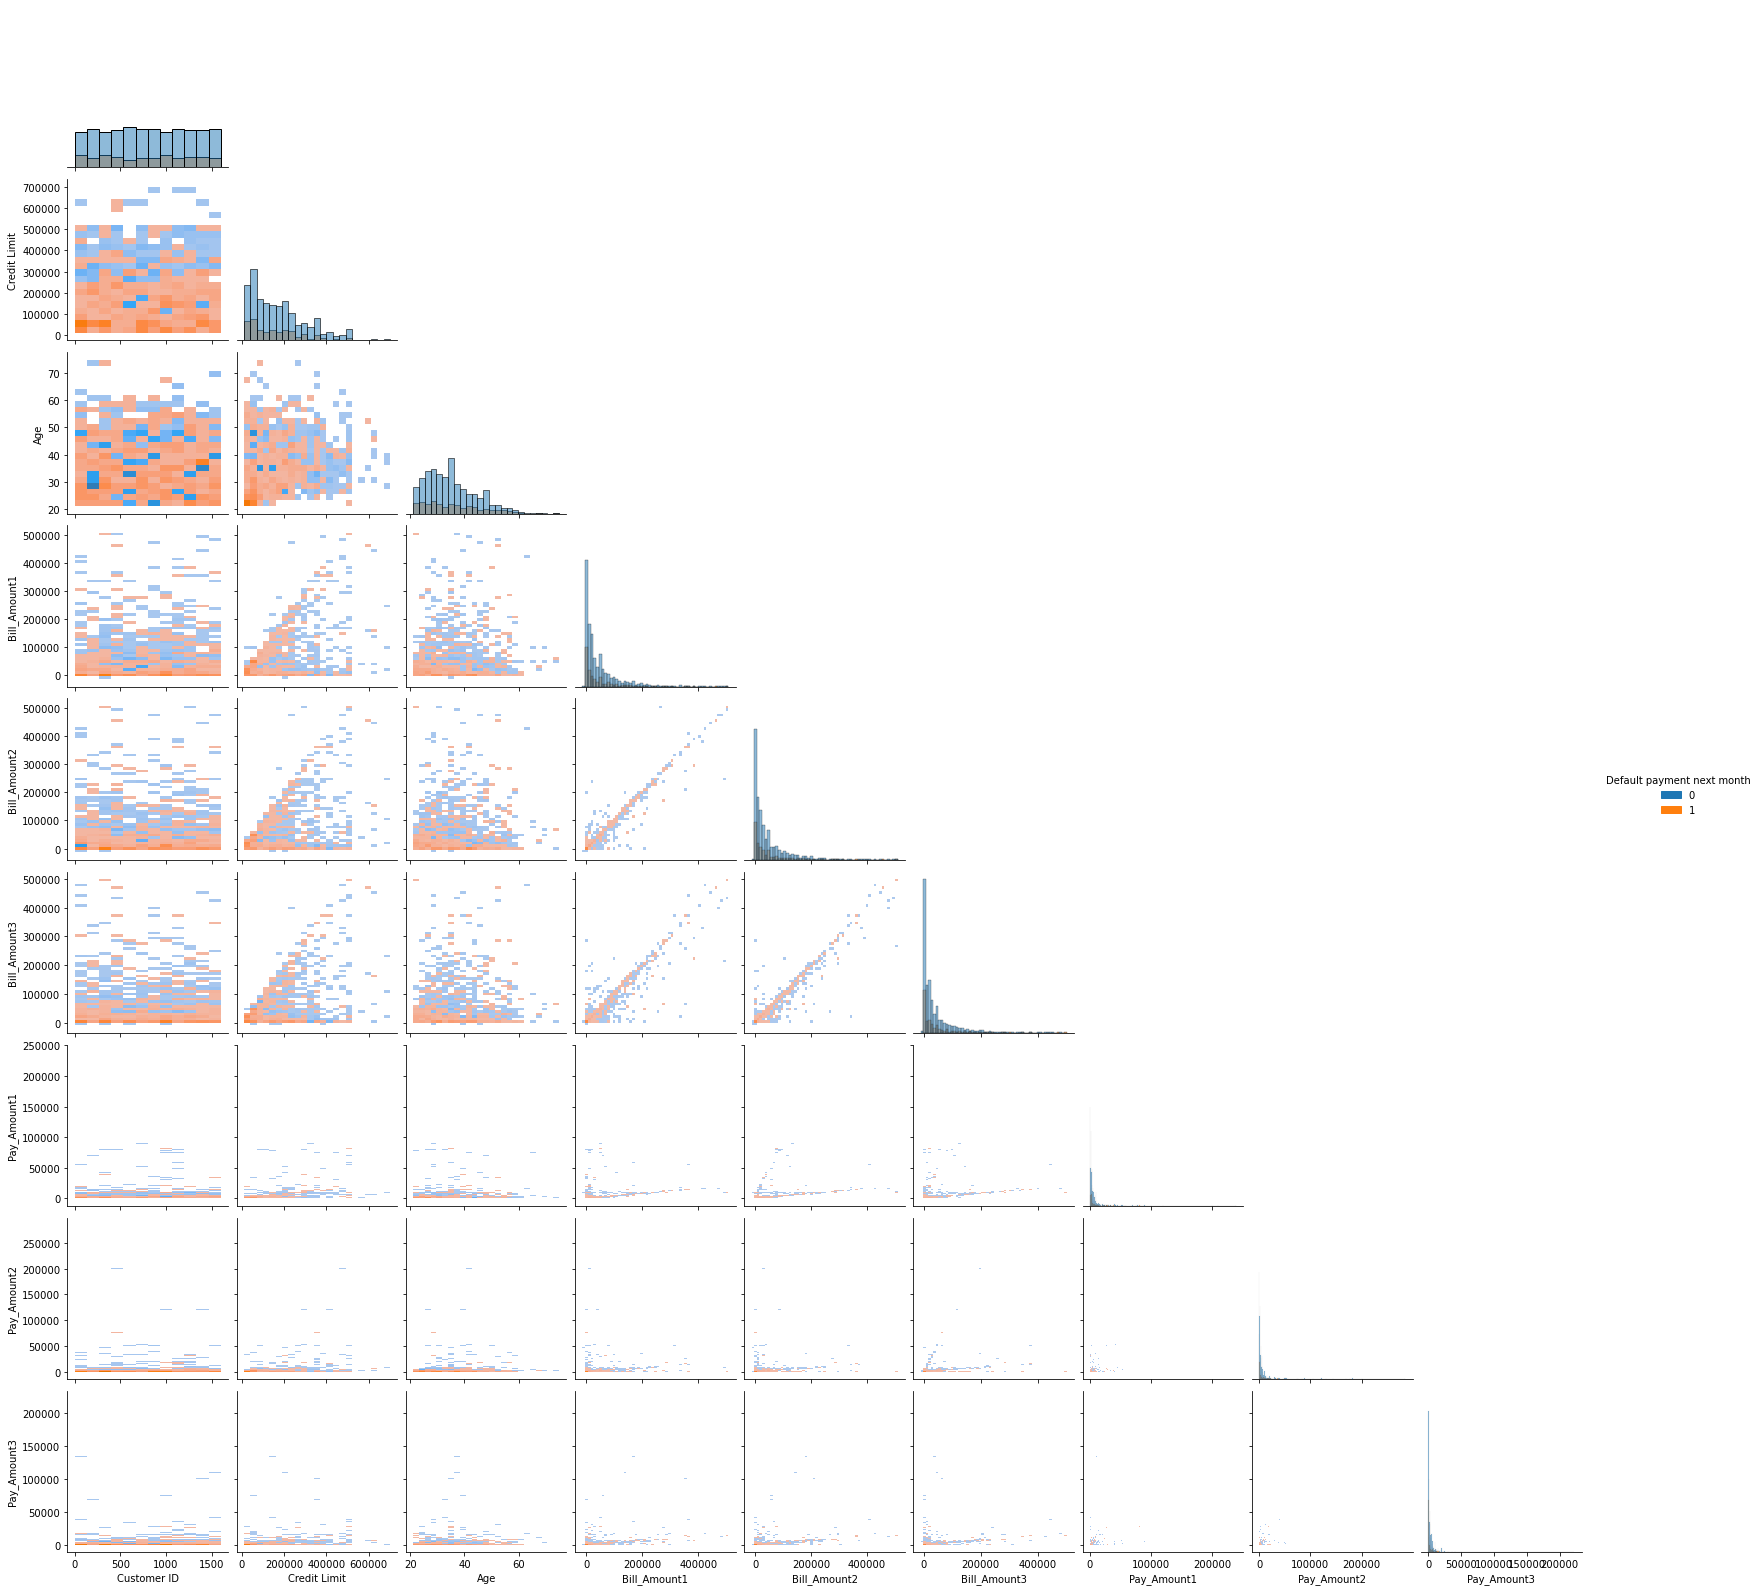

In [336]:
sns.pairplot(eda_data, corner = True, hue = "Default payment next month", kind = 'hist')
plt.show()

<hr>
<font size = 5>Feature Engineering</font>
<hr>

Generating new features to train the model on based on existing ones.

In [337]:
average_bill = []
average_payment = []
bill_exceed_payment = []
for i in analysis_data.itertuples():
    average_bill_score = (i[6] + i[7] + i[8])/3
    average_payment_score = (i[9] + i[10] + i[11])/3
    average_bill.append(average_bill_score)
    average_payment.append(average_payment_score)
    if(average_bill_score > average_payment_score):
        bill_exceed_payment.append(1)
    else:
        bill_exceed_payment.append(0)

analysis_data["average_bill"] = (average_bill)
analysis_data["average_payment"] = (average_payment)
analysis_data["average_bill_exceed_payment"] = (bill_exceed_payment)

display(analysis_data.head())

,Credit Limit,Gender,Education,Marriage Status,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,average_bill,average_payment,average_bill_exceed_payment
0,20000,female,univeresity,married,24,3913,3102,689,0,689,0,2568.000000,229.666667,1
1,120000,female,univeresity,single,26,2682,1725,2682,0,1000,1000,2363.000000,666.666667,1
2,90000,female,univeresity,single,34,29239,14027,13559,1518,1500,1000,18941.666667,1339.333333,1
3,50000,female,univeresity,married,37,46990,48233,49291,2000,2019,1200,48171.333333,1739.666667,1
4,50000,male,univeresity,married,57,8617,5670,35835,2000,36681,10000,16707.333333,16227.000000,1


<hr>
<font size = 5>Data Preparation </font>
<hr>

Performing one-hot encoding to prepare the data to train the models.

In [338]:
analysis_data = pd.get_dummies(analysis_data)
display(analysis_data.head())

,Credit Limit,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,average_bill,average_payment,average_bill_exceed_payment,Gender_female,Gender_male,Education_high school,Education_post-graduate,Education_univeresity,Marriage Status_married,Marriage Status_single
0,20000,24,3913,3102,689,0,689,0,2568.000000,229.666667,1,1,0,0,0,1,1,0
1,120000,26,2682,1725,2682,0,1000,1000,2363.000000,666.666667,1,1,0,0,0,1,0,1
2,90000,34,29239,14027,13559,1518,1500,1000,18941.666667,1339.333333,1,1,0,0,0,1,0,1
3,50000,37,46990,48233,49291,2000,2019,1200,48171.333333,1739.666667,1,1,0,0,0,1,1,0
4,50000,57,8617,5670,35835,2000,36681,10000,16707.333333,16227.000000,1,0,1,0,0,1,1,0


Using StandardScaler to standardize the data.

In [339]:
scaler = StandardScaler()
scaler.fit(analysis_data)
analysis_data = scaler.transform(analysis_data)

Splitting the data into training and testing datasets, with a 70/30 split.

In [340]:
X_train, X_test, y_train, y_test = train_test_split(analysis_data, target_data, test_size=0.3, random_state=42)

<hr>
<font size = 5>Oversampling</font><br>
<font size = 2>Note: We shall carry out oversampling to balance the dataset, and allow for better predictions to be made</font>
<hr>

Viewing the original distribution of the dataset.

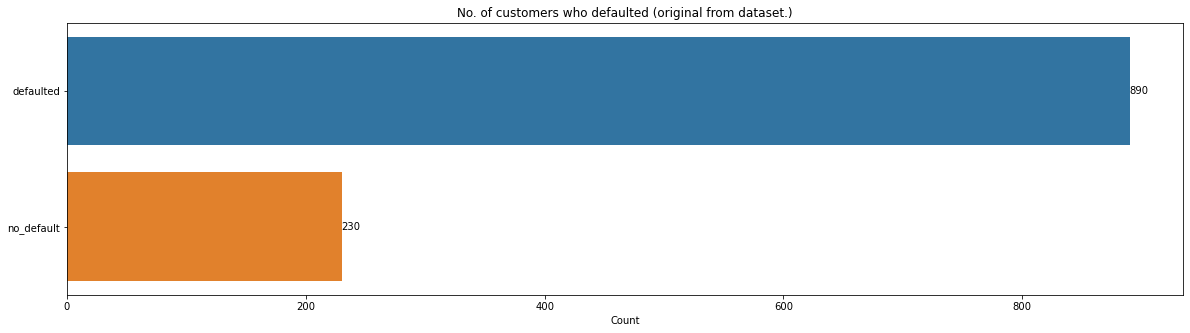

In [341]:
y_train.value_counts() 
initial_count = y_train.value_counts()
# display(initial_count)
initial_count_dict = dict(defaulted = initial_count[0], no_default=initial_count[1])
initial_count_dict = pd.DataFrame(data = initial_count_dict, index = ["Count"])
initial_count_dict = initial_count_dict.T
# display(initial_count_dict)
plt.figure(figsize = (20,5))
ax = sns.barplot(data = initial_count_dict, x = "Count", y = initial_count_dict.index)
ax.set(title = "No. of customers who defaulted (original from dataset.)")
for i in ax.containers:
    ax.bar_label(i,)

Attempting random oversampling to balance the dataset.

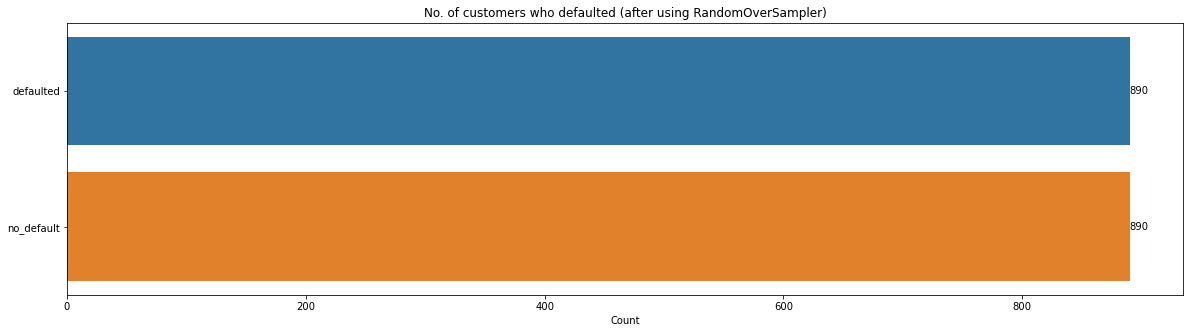

In [342]:
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

#viewing the results of the analysis
resample_count = y_ros.value_counts()
# display(resample_count)
resample_count_dict = dict(defaulted = resample_count[0], no_default=resample_count[1])
resample_count_dict = pd.DataFrame(data = resample_count_dict, index = ["Count"])
resample_count_dict = resample_count_dict.T
# display(resample_count_dict)
plt.figure(figsize = (20,5))
ax = sns.barplot(data = resample_count_dict, x = "Count", y = resample_count_dict.index)
ax.set(title = "No. of customers who defaulted (after using RandomOverSampler)")
for i in ax.containers:
    ax.bar_label(i,)

Attempting to perform oversampling using the SMOTE algorithm.

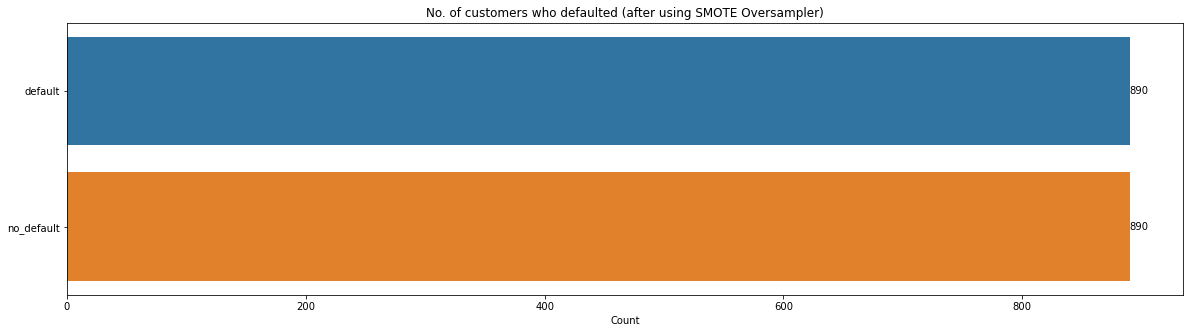

In [343]:
smote_os = SMOTE(random_state=42)
X_smote, y_smote = smote_os.fit_resample(X_train, y_train)
smote_count = y_ros.value_counts()
smote_count = dict(default = smote_count[0], no_default=smote_count[1])
smote_count = pd.DataFrame(data = smote_count, index = ["Count"])
smote_count = smote_count.T
# display(smote_count)
plt.figure(figsize = (20,5))
ax = sns.barplot(data = smote_count, x = "Count", y = smote_count.index)
ax.set(title = "No. of customers who defaulted (after using SMOTE Oversampler)")
for i in ax.containers:
    ax.bar_label(i,)

Calculating sample weights, for use in later algorithms.

In [344]:
def weight_function(y):
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    return class_weights[y.astype(int)]

<hr>
<font size = 5>Initial Modelling</font><br>
<font size = 2>Note: In this segment, we shall verify which method of balancing the dataset will result in the highest accuracy. We will use a KNearestNeighbours model with standardized parameters to verify which is best.
<hr>

Testing accuracy of RandomOverSampling.

              precision    recall  f1-score   support

           0       0.80      0.55      0.65       370
           1       0.26      0.53      0.35       110

    accuracy                           0.55       480
   macro avg       0.53      0.54      0.50       480
weighted avg       0.67      0.55      0.58       480

Accuracy for our testing dataset with tuning is : 54.7917%


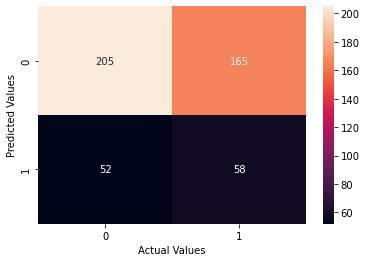

In [345]:
ros_knn = KNeighborsClassifier(n_jobs = -1, n_neighbors= 15)
ros_knn.fit(X_ros, y_ros)
y_ros_pred = ros_knn.predict(X_test)
test_accuracy=accuracy_score(y_test, y_ros_pred)*100

ax = sns.heatmap(confusion_matrix(y_test, y_ros_pred), annot= True, fmt = "g")
print(metrics.classification_report(y_test,  y_ros_pred))

ax.set(ylabel = "Predicted Values", xlabel = "Actual Values")
print("Accuracy for our testing dataset with tuning is : {:.4f}%".format(test_accuracy) )

Testing accuracy of SMOTE Oversampling.

              precision    recall  f1-score   support

           0       0.79      0.49      0.61       370
           1       0.25      0.57      0.35       110

    accuracy                           0.51       480
   macro avg       0.52      0.53      0.48       480
weighted avg       0.67      0.51      0.55       480

Accuracy for our testing dataset with tuning is : 51.0417%


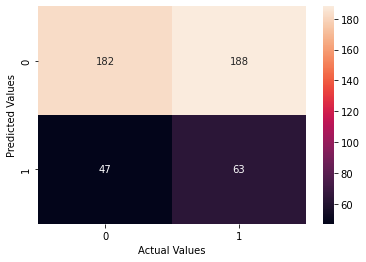

In [346]:
smote_knn = KNeighborsClassifier(n_jobs = -1, n_neighbors= 15)
smote_knn.fit(X_smote, y_smote)
y_smote_pred = smote_knn.predict(X_test)
test_accuracy=accuracy_score(y_test, y_smote_pred)*100

ax = sns.heatmap(confusion_matrix(y_test, y_smote_pred), annot= True, fmt = "g")
print(metrics.classification_report(y_test,  y_smote_pred))
ax.set(ylabel = "Predicted Values", xlabel = "Actual Values")
print("Accuracy for our testing dataset with tuning is : {:.4f}%".format(test_accuracy) )

In [347]:
# cw_knn = KNeighborsClassifier(n_jobs = -1, n_neighbors= 15, class_weight = y_train)
# cw_knn.fit(X_train, y_train)
# y_cw_pred = cw_knn.predict(X_test)
# test_accuracy=accuracy_score(y_test, y_cw_pred)*100

# ax = sns.heatmap(confusion_matrix(y_test, y_cw_pred), annot= True, fmt = "g")
# print(metrics.classification_report(y_test,  y_cw_pred))
# ax.set(ylabel = "Predicted Values", xlabel = "Actual Values")
# print("Accuracy for our testing dataset with tuning is : {:.4f}%".format(test_accuracy) )

In [348]:
X_train = X_ros
y_train = y_ros

Creating a dummy model to use as a benchmark against the other models.

In [349]:
dummy_model = DummyClassifier()
dummy_model.fit(X_train, y_train)
accuracy = dummy_model.score(X_train, y_train)
print("Accuracy for our training dataset using the dummy model is : {:.4f}%".format(accuracy*100) )

Accuracy for our training dataset using the dummy model is : 50.0000%


<hr>
<font size = 5>Training models</font>
<hr>

Attempting to train and tune a kNearestNeighbors model with GridSearchCV<br>

Finding the parameters which yield the best accuracy for the training dataset.

In [350]:
param_grid = dict(n_neighbors=list(range(1,35)), weights = ['uniform', 'distance'], algorithm = ['ball_tree', 'kd_tree', 'brute'])
knn = KNeighborsClassifier(n_jobs = -1)
grid = GridSearchCV(knn, param_grid,scoring='accuracy', return_train_score=False, verbose=1)
knn_search=grid.fit(X_train, y_train)
print(knn_search.best_params_)
accuracy = knn_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.4f}%".format(accuracy) )

Fitting 5 folds for each of 204 candidates, totalling 1020 fits
{'algorithm': 'ball_tree', 'n_neighbors': 2, 'weights': 'distance'}
Accuracy for our training dataset with tuning is : 87.2472%


Attempting to train and tune a RandomForest model using GridSearchCV

In [351]:
n_est_arr = list(np.arange(1,10))
for i in list(np.arange(10,100,10)):n_est_arr.append(i)

param_grid = dict(n_estimators= n_est_arr, max_depth= np.arange(1,10,2), max_features =['sqrt', 'log2'])
rfc = RandomForestClassifier(n_jobs = -1)
rfc_grid = GridSearchCV(rfc, param_grid = param_grid, return_train_score=False, verbose=1)
rfc_search = rfc_grid.fit(X_train, y_train)
print(rfc_search.best_params_)
accuracy = rfc_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.4f}%".format(accuracy) )

Fitting 5 folds for each of 180 candidates, totalling 900 fits
{'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 80}
Accuracy for our training dataset with tuning is : 88.8202%


Attempting to train and tune a SVC model using GridSearchCV

In [352]:
# param_grid = dict(C = np.arange(0.1,100,0.1))
# svc = SVC(max_iter= -1)
# svc_grid = GridSearchCV(svc, param_grid, verbose = 1)
# svc_search = svc_grid.fit(X_train, y_train)
# print(svc_search.best_params_)
# accuracy = svc_search.best_score_*100
# print("Accuracy for our training dataset with tuning is : {:.4f}%".format(accuracy) )


Attempting to train and tune a Bernoulli Naive Bayes model using GridSearchCV <br>
<font size = 2>Note: Despite there being several variants of Naive Bayes classifiers used in Machine Learning, I elected to use the Bernoulli Naive Bayes method, as it is the most appropriate model to use when dealing with binary or Boolean features.</font>

In [353]:
param_grid = dict(alpha = np.arange(0.001,10,0.1))
ber_nb = BernoulliNB()
ber_grid = GridSearchCV(ber_nb, param_grid, verbose = 1)
ber_search = ber_grid.fit(X_train, y_train)
print(ber_search.best_params_)
accuracy = ber_search.best_score_*100
print("Accuracy for our training dataset with tuning is : {:.4f}%".format(accuracy) )


Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'alpha': 0.6010000000000001}
Accuracy for our training dataset with tuning is : 55.0562%


Attempting to train and tune a GradientBoostingClassifier model using GridSearchCV

In [354]:
param_grid = dict(loss = ["exponential"], learning_rate = np.arange(0.1, 1, 0.10), n_estimators = np.arange(1, 100, 10), max_depth = np.arange(1,11,1))
gbc = GradientBoostingClassifier()
gbc_grid = GridSearchCV(gbc, param_grid, verbose = 1)
gbc_search = gbc_grid.fit(X_train, y_train)
print(gbc_search.best_params_)
accuracy = gbc_search.best_score_*100
print("Accuracy for our training dataset with tuning is : {:.4f}%".format(accuracy))

Fitting 5 folds for each of 900 candidates, totalling 4500 fits
{'learning_rate': 0.7000000000000001, 'loss': 'exponential', 'max_depth': 10, 'n_estimators': 91}
Accuracy for our training dataset with tuning is : 95.0562%


<hr>
<font size = 5 >Evaluating the model</font>
<hr>

Training a model with the parameters which yieleded the best training accuracy to predict the results of the test data for KNeighborsClassifier

The parameters used for KNeighboursClassifier are:
algorithm, using value ball_tree
n_neighbors, using value 2
weights, using value distance
              precision    recall  f1-score   support

           0       0.76      0.81      0.78       370
           1       0.19      0.15      0.17       110

    accuracy                           0.66       480
   macro avg       0.48      0.48      0.48       480
weighted avg       0.63      0.66      0.64       480

Accuracy for our testing dataset with tuning is : 65.8333%
The f1 score of our tuned model is 0.6583333333333333


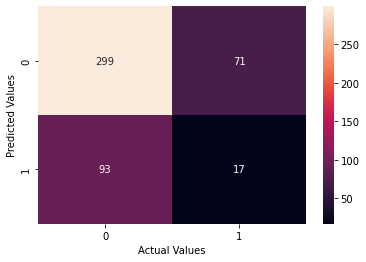

In [355]:
print(f"The parameters used for KNeighboursClassifier are:")
for parameter in knn_search.best_params_:
    print(f"{parameter}, using value {knn_search.best_params_[parameter]}")

knn = KNeighborsClassifier(algorithm=knn_search.best_params_["algorithm"], n_neighbors = knn_search.best_params_["n_neighbors"], weights = knn_search.best_params_["weights"])
knn.fit(X_train, y_train)
knn_y_test_hat = knn.predict(X_test)
test_accuracy=accuracy_score(y_test,knn_y_test_hat)*100
knn_f1_score = f1_score(y_test, knn_y_test_hat, average = "micro")

ax = sns.heatmap(confusion_matrix(y_test,knn_y_test_hat), annot= True, fmt = "g")
print(metrics.classification_report(y_test, knn_y_test_hat, zero_division= 0))
ax.set(ylabel = "Predicted Values", xlabel = "Actual Values")

print("Accuracy for our testing dataset with tuning is : {:.4f}%".format(test_accuracy) )
print(f"The f1 score of our tuned model is {knn_f1_score}")

Training a model with the parameters which yieleded the best training accuracy to predict the results of the test data for RandomForestClassifier

The parameters used for RandomForestClassifier are:
max_depth, using value 9
max_features, using value sqrt
n_estimators, using value 80
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       370
           1       0.41      0.28      0.33       110

    accuracy                           0.74       480
   macro avg       0.61      0.58      0.59       480
weighted avg       0.71      0.74      0.72       480

Accuracy for our testing dataset with tuning is : 74.1667%
The f1 score of our tuned model is 0.7237295434969853


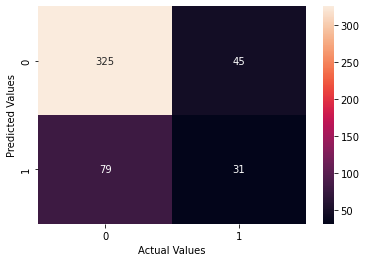

In [356]:
print(f"The parameters used for RandomForestClassifier are:")
for parameter in rfc_search.best_params_:
    print(f"{parameter}, using value {rfc_search.best_params_[parameter]}")

rfc = RandomForestClassifier(max_depth = rfc_search.best_params_["max_depth"], max_features= rfc_search.best_params_["max_features"], n_estimators=rfc_search.best_params_["n_estimators"])
rfc.fit(X_train, y_train)
rfc_y_test_hat = rfc.predict(X_test)
test_accuracy=accuracy_score(y_test, rfc_y_test_hat)*100
rfc_f1_score = f1_score(y_test, rfc_y_test_hat, average = "weighted")

ax = sns.heatmap(confusion_matrix(y_test,rfc_y_test_hat), annot= True, fmt = "g")
print(metrics.classification_report(y_test, rfc_y_test_hat, zero_division = 0))
ax.set(ylabel = "Predicted Values", xlabel = "Actual Values")

print("Accuracy for our testing dataset with tuning is : {:.4f}%".format(test_accuracy) )
print(f"The f1 score of our tuned model is {rfc_f1_score}")


The parameters used for GradientBoostClassifier are:
learning_rate, using value 0.7000000000000001
loss, using value exponential
max_depth, using value 10
n_estimators, using value 91
              precision    recall  f1-score   support

           0       0.78      0.94      0.85       370
           1       0.31      0.09      0.14       110

    accuracy                           0.75       480
   macro avg       0.54      0.52      0.50       480
weighted avg       0.67      0.75      0.69       480

Accuracy for our testing dataset with tuning is : 74.5833%
The f1 score of our tuned model is 0.688144965965311


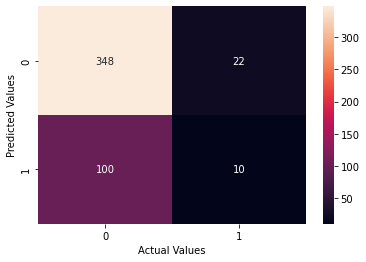

In [357]:
print(f"The parameters used for GradientBoostClassifier are:")
for parameter in gbc_search.best_params_:
    print(f"{parameter}, using value {gbc_search.best_params_[parameter]}")

gbc = GradientBoostingClassifier(loss = gbc_search.best_params_["loss"], learning_rate = gbc_search.best_params_["learning_rate"], n_estimators = gbc_search.best_params_["n_estimators"], max_depth = gbc_search.best_params_["max_depth"])
gbc.fit(X_train, y_train)
gbc_y_test_hat = gbc.predict(X_test)
test_accuracy = accuracy_score(y_test, gbc_y_test_hat) * 100
gbc_f1_score = f1_score(y_test, gbc_y_test_hat, average = 'weighted')

ax = sns.heatmap(confusion_matrix(y_test, gbc_y_test_hat), annot = True, fmt = 'g')
print(classification_report(y_test, gbc_y_test_hat, zero_division= 0))
ax.set(ylabel = "Predicted Values", xlabel = "Actual Values")

print("Accuracy for our testing dataset with tuning is : {:.4f}%".format(test_accuracy) )
print(f"The f1 score of our tuned model is {gbc_f1_score}")

Since the goal of the bank is to reduce risk, we should err on the side of caution, and prioritize the "Recall" metric, as it focuses on the model's ability to identify positive instances accurately. Then, we should look at the "Precision" metric, as it focuses on the "correct-ness" of positive predictions. <br><br>
We focus on the "Recall" metric as we would want to ensure that the model is good at guessing when people default. <br><br>
The "Precision" metric is focused on, as we want to ensure that the model is still accurate overall.<br><br>
However, the f1_score metric is also important, as it gives the mean between the mean between precision and recall. (1 is best, 0 is worst.)

__References__: <br>
1) Investopedia. (2023). Default: What It Means, What Happens When You Default, Examples. [online] Available at: https://www.investopedia.com/terms/d/default2.asp#:~:text=A%20default%20is%20a%20missed,or%20your%20monthly%20mortgage%20payment. [Accessed 5 May 2023].
<br>
2)